In [1]:
import cv2
import numpy as np
import pandas as pd
import pickle as cPickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score,confusion_matrix,multilabel_confusion_matrix,recall_score

In [2]:
cv2.__version__
import sklearn
sklearn.__version__

'0.23.1'

Let us first read the train and test files

In [3]:
train_images_filenames = cPickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('train_labels.dat','rb'))
test_labels = cPickle.load(open('test_labels.dat','rb'))

In [4]:
train_images_filenames[12]

'../../Databases/MIT_split/train/Opencountry/fie26.jpg'

We create a SIFT object detector and descriptor

In [5]:
SIFTdetector = cv2.SIFT_create(nfeatures=300)

We compute the SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

In [6]:
Train_descriptors = []
Train_label_per_descriptor = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kpt,des=SIFTdetector.detectAndCompute(gray,None)
#     des=compute_dense_sift(gray,SIFTdetector)
    Train_descriptors.append(des)
    Train_label_per_descriptor.append(labels)

D=np.vstack(Train_descriptors)

In [182]:
print(len(Train_descriptors[0][1][1]))
Train_descriptors[0][1][3]

128


array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,
         3.,   5.,  25.,   3.,   0.,   0.,   0.,  39.,   6.,   3.,   5.,
         0.,   0.,   0.,  14.,   5.,   0.,   0.,   0.,   1.,   1.,   0.,
         6.,   0.,   0.,   0.,   0.,   3.,   6.,   4.,   1., 111.,  80.,
       161., 153.,   6.,   0.,   0.,  21., 161.,  43.,  23.,  17.,   0.,
         0.,   0., 161.,  26.,   0.,   0.,   0.,   2.,   4.,   0.,  28.,
         0.,   0.,   0.,   0.,   8.,  29.,  29.,   4., 161.,  98.,  83.,
        50.,   0.,   0.,  89., 161., 161.,  57.,   3.,   0.,   0.,   0.,
         5., 161.,  12.,   1.,   1.,   0.,   0.,   0.,   0.,   3.,   0.,
         0.,   3.,   1.,   0.,   1.,   2.,   0.], dtype=float32)

We now compute a k-means clustering on the descriptor space

In [7]:
# k = 128
k=128
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

MiniBatchKMeans(batch_size=2560, compute_labels=False, n_clusters=128,
                random_state=42, reassignment_ratio=0.0001, verbose=False)

And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [8]:
visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
for i in range(len(Train_descriptors)):
    words=codebook.predict(Train_descriptors[i])
    visual_words[i,:]=np.bincount(words,minlength=k)

We build a k-nn classifier and train it with the train descriptors

In [114]:
knn = KNeighborsClassifier(n_neighbors=37,n_jobs=-1,metric='manhattan')
knn.fit(visual_words, train_labels) 

KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=37)

In [75]:
pca = PCA(n_components=64)
VWpca = pca.fit_transform(visual_words)
knnpca = KNeighborsClassifier(n_neighbors=14,n_jobs=-1,metric='manhattan')
knnpca.fit(VWpca, train_labels) 

KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=14)

We end up computing the test descriptors and compute the accuracy of the model

In [115]:
visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kpt,des=SIFTdetector.detectAndCompute(gray,None)
#     des=compute_dense_sift(gray,SIFTdetector)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k)

In [116]:
accuracy = 100*knn.score(visual_words_test, test_labels)
print(accuracy)
scores = cross_val_score(knn, visual_words_test, test_labels, cv=5)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 200))

51.6728624535316
[0.49382716 0.49382716 0.44099379 0.48447205 0.47204969]
Accuracy: 47.70 (+/- 3.94)


Dimensionality reduction, with PCA and LDA

In [60]:
pca = PCA(n_components=64)
VWpca = pca.fit_transform(visual_words)
knnpca = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knnpca.fit(VWpca, train_labels) 
vwtestpca = pca.transform(visual_words_test)
accuracy = 100*knnpca.score(vwtestpca, test_labels)
print(accuracy)

55.14250309789344


In [15]:
lda = LinearDiscriminantAnalysis(n_components=7)
VWlda = lda.fit_transform(visual_words,train_labels)
knnlda = KNeighborsClassifier(n_neighbors=14,n_jobs=-1,metric='manhattan')
knnlda.fit(VWlda, train_labels) 
vwtestlda = lda.transform(visual_words_test)
accuracy = 100*knnlda.score(vwtestlda, test_labels)
print(accuracy)

60.223048327137555


In [64]:
len(visual_words)

1881

In [65]:
len(train_labels)

1881

## My own code

In [144]:
accuracy = 100*knn.score(visual_words_test, test_labels)
print(accuracy)
# print(precision)
y_pred= knn.predict(visual_words_test)
precision=100*precision_score(y_pred, test_labels,average='macro')
recall=100*recall_score(y_pred, test_labels,average='macro')
print(precision,recall)

56.877323420074354
57.14529120333209 59.115441921219094


KNN function to loop

In [212]:
def run_different_knn(neigh,metric):
    knn = KNeighborsClassifier(n_neighbors=neigh,n_jobs=-1,metric=metric)
    knn.fit(visual_words, train_labels)
    
    visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
    for i in range(len(test_images_filenames)):
        filename=test_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kpt,des=SIFTdetector.detectAndCompute(gray,None)
#         des=compute_dense_sift(gray,SIFTdetector)
        words=codebook.predict(des)
        visual_words_test[i,:]=np.bincount(words,minlength=k)
    
    accuracy = 100*knn.score(visual_words_test, test_labels)
    y_pred= knn.predict(visual_words_test)
    precision=100*precision_score(y_pred, test_labels,average='macro')
    recall=100*recall_score(y_pred, test_labels,average='macro')
    
    return precision,recall,accuracy

DENSE SIFT

In [197]:
# ima=cv2.imread(r'C:\Users\adama\OneDrive/Dokumenty/Master of Computer Vision/M3/Databases/MIT_split/train/forest/art114.jpg')
# gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)

def compute_dense_sift(gray,sift):
    step_size = 5
    kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                        for x in range(0, gray.shape[1], step_size)]
    dense_feat = sift.compute(gray, kp)
    dense_feat_des = dense_feat[1]
    return dense_feat_des

128
0.0


PCA

In [ ]:
pca = PCA(n_components=64)
VWpca = pca.fit_transform(visual_words)
knnpca = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knnpca.fit(VWpca, train_labels) 
vwtestpca = pca.transform(visual_words_test)
accuracy = 100*knnpca.score(vwtestpca, test_labels)
print(accuracy)

In [201]:
def run_different_knn_PCA(neigh,metric,n_pca):
    pca = PCA(n_components=n_pca)
    VWpca = pca.fit_transform(visual_words)
    knnpca = KNeighborsClassifier(n_neighbors=neigh,n_jobs=-1,metric=metric)
    knnpca.fit(VWpca, train_labels) 
#     knn = KNeighborsClassifier(n_neighbors=neigh,n_jobs=-1,metric=metric)
#     knn.fit(visual_words, train_labels)
    
    visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
    for i in range(len(test_images_filenames)):
        filename=test_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
#         kpt,des=SIFTdetector.detectAndCompute(gray,None)
        des=compute_dense_sift(gray,SIFTdetector)
        words=codebook.predict(des)
        visual_words_test[i,:]=np.bincount(words,minlength=k)
    
    vwtestpca = pca.transform(visual_words_test)
    accuracy = 100*knnpca.score(vwtestpca, test_labels)
    y_pred = knnpca.predict(vwtestpca)
    
#     accuracy = 100*knn.score(visual_words_test, test_labels)
#     y_pred= knn.predict(visual_words_test)
    precision=100*precision_score(y_pred, test_labels,average='macro')
    recall=100*recall_score(y_pred, test_labels,average='macro')
    
    return precision,recall,accuracy

In [12]:
def run_different_knn_LDA(neigh,metric,n_lda):
    lda = LinearDiscriminantAnalysis(n_components=n_lda)
    VWlda = lda.fit_transform(visual_words,train_labels)
    knnlda = KNeighborsClassifier(n_neighbors=neigh,n_jobs=-1,metric=metric)
    knnlda.fit(VWlda, train_labels) 
#     knn = KNeighborsClassifier(n_neighbors=neigh,n_jobs=-1,metric=metric)
#     knn.fit(visual_words, train_labels)
    
    visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
    for i in range(len(test_images_filenames)):
        filename=test_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kpt,des=SIFTdetector.detectAndCompute(gray,None)
#         des=compute_dense_sift(gray,SIFTdetector)
        words=codebook.predict(des)
        visual_words_test[i,:]=np.bincount(words,minlength=k)
    
    vwtestlda = lda.transform(visual_words_test)
    accuracy = 100*knnlda.score(vwtestlda, test_labels)
    
    y_pred = knnlda.predict(vwtestlda)
    
#     accuracy = 100*knn.score(visual_words_test, test_labels)
#     y_pred= knn.predict(visual_words_test)
    precision=100*precision_score(y_pred, test_labels,average='macro')
    recall=100*recall_score(y_pred, test_labels,average='macro')
    
    return precision,recall,accuracy

# Main analysis

In [190]:
data_confusion=[]
metric=['euclidean','manhattan','chebyshev','minkowski']
from datetime import datetime

today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(dt_string)
for item in range(1,53,2):
    today = datetime.now()
    dt_string = today.strftime("%H:%M:%S")
    print(f"{dt_string} started doing knn={item}")
    for m in metric:
        precision,recall,accuracy=run_different_knn_PCA(item,m)
        data_confusion.append([item,precision,recall, accuracy,m,5,0,1])
today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(f"{dt_string} finished")
df=pd.DataFrame(data_confusion, columns=['knn','precision','recall','accuracy','metric','dense','pca','lda'])

18:57:33
18:57:33 started doing knn=1
18:58:41 started doing knn=3


KeyboardInterrupt: 

In [202]:
### different PCA number
data_confusion=[]
metric=['euclidean','manhattan','chebyshev','minkowski']
from datetime import datetime

today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(dt_string)
for item in range(2,110,10):
    today = datetime.now()
    dt_string = today.strftime("%H:%M:%S")
    print(f"{dt_string} started doing pca={item}")
    precision,recall,accuracy=run_different_knn_PCA(27,metric[1],item)
    data_confusion.append([item,precision,recall, accuracy,metric[1],0,item,0])
    
today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(f"{dt_string} finished")
df=pd.DataFrame(data_confusion, columns=['knn','precision','recall','accuracy','metric','dense','pca','lda'])

19:10:51
19:10:51 started doing pca=2
19:11:17 started doing pca=12
19:11:42 started doing pca=22
19:12:12 started doing pca=32
19:12:41 started doing pca=42
19:13:05 started doing pca=52
19:13:34 started doing pca=62
19:14:04 started doing pca=72
19:14:31 started doing pca=82
19:14:59 started doing pca=92
19:15:30 started doing pca=102
19:15:55 finished


In [14]:
### different LDA number
data_confusion=[]
metric=['euclidean','manhattan','chebyshev','minkowski']
from datetime import datetime

today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(dt_string)
for item in range(1,8,1):
    today = datetime.now()
    dt_string = today.strftime("%H:%M:%S")
    print(f"{dt_string} started doing pca={item}")
    precision,recall,accuracy=run_different_knn_LDA(27,metric[1],item)
    data_confusion.append([item,precision,recall, accuracy,metric[1],0,0,item])
    
today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(f"{dt_string} finished")
df=pd.DataFrame(data_confusion, columns=['knn','precision','recall','accuracy','metric','dense','pca','lda'])

13:26:51
13:26:51 started doing pca=1
13:27:08 started doing pca=2
13:27:26 started doing pca=3
13:27:51 started doing pca=4
13:28:13 started doing pca=5
13:28:31 started doing pca=6
13:28:50 started doing pca=7
13:29:11 finished


In [20]:
with open('N300K128KNN27PCA02LDA0-7DENSE0.pkl','wb') as f:
     cPickle.dump(df,f)

In [156]:
with open('N300K128KNN1_51_ALL_FINAL.pkl','wb') as f:
     cPickle.dump(df_all,f)

In [35]:
df_all=pd.DataFrame

In [21]:
with open('N300K128KNN27PCA02LDA0-7DENSE0.pkl','rb') as f:
    df_new=cPickle.load(f)

In [214]:
df_all=df_all.append(df_new,ignore_index=True)

In [30]:
df_new.accuracy.astype(int)

0    32.837670
1    47.087980
2    52.664188
3    56.505576
4    59.727385
5    60.346964
6    62.453532
Name: accuracy, dtype: float64

In [179]:
df_all[(df_all.lda==1)&(df_all.dense==0)]

,knn,precision,recall,accuracy,metric,dense,pca,lda
192,1,52.843323,53.488828,52.664188,euclidean,0,0,1
193,1,52.089158,52.598718,51.796778,manhattan,0,0,1
194,1,52.873887,53.878570,52.540273,chebyshev,0,0,1
195,1,52.843323,53.488828,52.664188,minkowski,0,0,1
196,3,57.544235,59.269422,57.249071,euclidean,0,0,1
...,...,...,...,...,...,...,...,...
291,49,61.891209,62.465827,61.710037,minkowski,0,0,1
292,51,62.179445,62.727663,61.957869,euclidean,0,0,1
293,51,62.117227,62.418694,61.833953,manhattan,0,0,1
294,51,61.554155,62.092528,61.338290,chebyshev,0,0,1


In [152]:
df_all.pca=df_all.pca.astype(int)

In [153]:
df_new=df_all

In [58]:
df_new=df_new.append(df_new_5,ignore_index=True)

In [12]:
# print(df)
# df['precision']=df['precision']/100
# df['recall']=df['recall']/100
df_eucl=df_new.metric=='euclidean'
df[df_eucl].plot.scatter(x='precision',y='recall',xlim=(0,100),ylim=(0,100),cmap='viridis')

NameError: name 'df' is not defined

max
     knn  precision     recall   accuracy     metric  dense  pca  lda
10   27  74.946304  75.423603  73.853779  manhattan      5  102    0


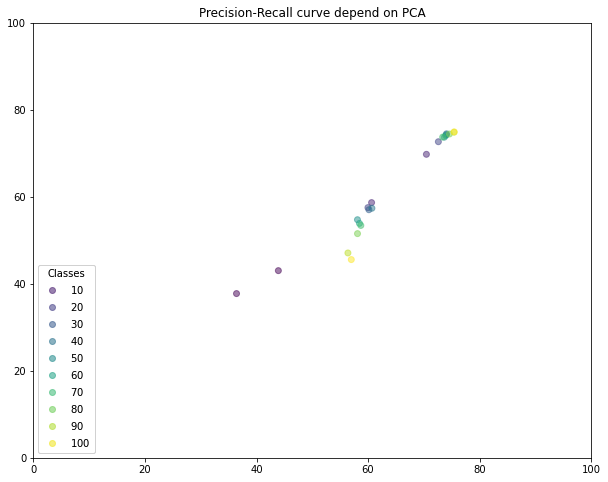

In [224]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set(title='Precision-Recall curve depend on PCA', xlim=(0,100), ylim=(0,100))

df2=df_new
# print(df2)
print("max\n",df2[df2.precision==df2.precision.max()])
# print(df2[df2.recall==df2.recall.max()])
scatter=ax.scatter(df2.recall, df2.precision, c=df2.pca,
           label=df2.pca,
           marker='o', alpha=.5,
           cmap='viridis')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

PLOT by metric

max
      knn  precision     recall   accuracy     metric  dense  pca  lda
117   27  78.640697  78.617144  78.314746  manhattan      5    0    0
     knn  precision     recall   accuracy     metric  dense  pca  lda
117   27  78.640697  78.617144  78.314746  manhattan      5    0    0


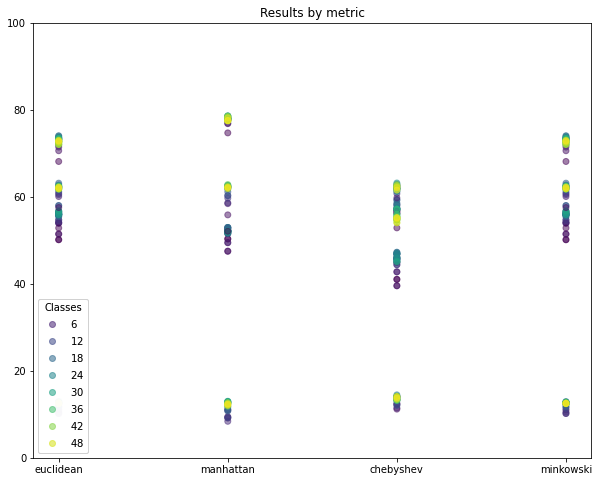

In [175]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set(title='Results by metric',ylim=(0,100))

df2=df_new
# print(df2)
print("max\n",df2[df2.precision==df2.precision.max()])
print(df2[df2.recall==df2.recall.max()])
scatter=ax.scatter(df2.metric, df2.precision, c=df2.knn,
           label=df2.knn,
           marker='o', alpha=.5,
           cmap='viridis')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

### Graph showing metrices with knn values from 0-51 and dense 0 and 5 and lda = 0 and pca = 0

In [169]:
df2_man_d0=df_new[(df_new.metric=='manhattan')&(df_new.dense==0)&(df_new.lda==0)&(df_new.pca==0)]
df2_euc_d0=df_new[(df_new.metric=='euclidean')&(df_new.dense==0)&(df_new.lda==0)&(df_new.pca==0)]
df2_che_d0=df_new[(df_new.metric=='chebyshev')&(df_new.dense==0)&(df_new.lda==0)&(df_new.pca==0)]
df2_man_d5=df_new[(df_new.metric=='manhattan')&(df_new.dense==5)&(df_new.lda==0)&(df_new.pca==0)]
df2_euc_d5=df_new[(df_new.metric=='euclidean')&(df_new.dense==5)&(df_new.lda==0)&(df_new.pca==0)]
df2_che_d5=df_new[(df_new.metric=='chebyshev')&(df_new.dense==5)&(df_new.lda==0)&(df_new.pca==0)]

In [32]:
df_new.dense=df_new.dense.astype(int)

max
      knn  precision     recall   accuracy     metric  dense  pca  lda
117   27  78.640697  78.617144  78.314746  manhattan      5    0    0


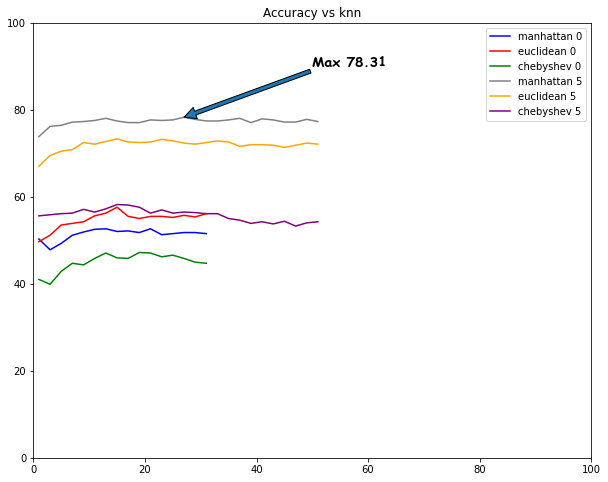

In [170]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set(title='Accuracy vs knn', xlim=(0,100), ylim=(0,100))

print("max\n",df2[df2.precision==df2.precision.max()])
# print(df2[df2.recall==df2.recall.max()])
ax.plot(df2_man_d0.knn, df2_man_d0.accuracy, color='b', label='manhattan 0')
ax.plot(df2_euc_d0.knn, df2_euc_d0.accuracy, color='r', label='euclidean 0')
ax.plot(df2_che_d0.knn, df2_che_d0.accuracy, color='g', label='chebyshev 0')
ax.plot(df2_man_d5.knn, df2_man_d5.accuracy, color='gray', label='manhattan 5')
ax.plot(df2_euc_d5.knn, df2_euc_d5.accuracy, color='orange', label='euclidean 5')
ax.plot(df2_che_d5.knn, df2_che_d5.accuracy, color='purple', label='chebyshev 5')
ax.legend()

max_val = max(df_new.accuracy)
max_idx = df_new.knn[df_new.accuracy.idxmax()]
# ax.annotate("Max {:.2f}".format(max_val), xy=(max_idx, max_val),
#            weight='bold', size=14)

# arrowprops is a mpl.patches.FancyArrowPatch
_ = ax.annotate("Max {:.2f}".format(max_val), xy=(max_idx, max_val),
                weight='bold', size=14, 
                xytext=(.5, .9),
                textcoords='axes fraction',
                family='comic sans ms',
                arrowprops={})

max
     knn  precision     recall   accuracy     metric  dense  pca  lda
10   27  74.946304  75.423603  73.853779  manhattan      5  102    0


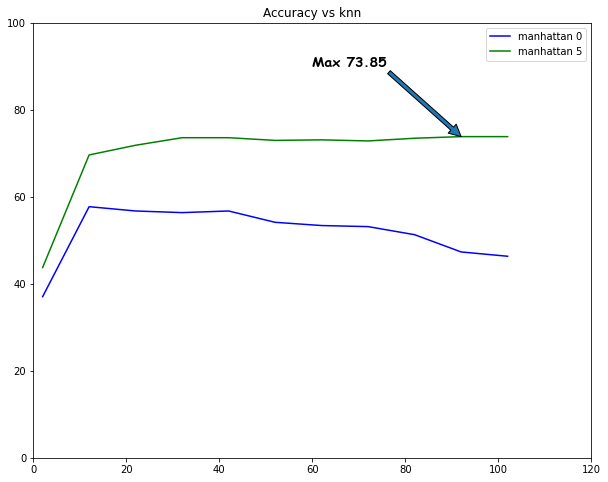

In [231]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set(title='Accuracy vs knn', xlim=(0,120), ylim=(0,100))
df2=df_new
df2_dense0=df_new[(df_new.dense==0)]
df2_dense5=df_new[(df_new.dense==5)]
print("max\n",df2[df2.precision==df2.precision.max()])
# print(df2[df2.recall==df2.recall.max()])
ax.plot(df2_dense0.pca, df2_dense0.accuracy, color='b', label='manhattan 0')
ax.plot(df2_dense5.pca, df2_dense5.accuracy, color='g', label='manhattan 5')
ax.legend()

max_val = max(df2_dense5.accuracy)
max_idx = df2_dense5.pca[df2_dense5.accuracy.idxmax()]
# ax.annotate("Max {:.2f}".format(max_val), xy=(max_idx, max_val),
#            weight='bold', size=14)

# arrowprops is a mpl.patches.FancyArrowPatch
_ = ax.annotate("Max {:.2f}".format(max_val), xy=(max_idx, max_val),
                weight='bold', size=14, 
                xytext=(.5, .9),
                textcoords='axes fraction',
                family='comic sans ms',
                arrowprops={})

### Showing that PCA does not impact KNN algorithm where LDA improves it by 10% for not dense SIFT

In [174]:
df_new[(df_new.knn==27)&(df_new.dense==0)&(df_new.metric=='manhattan')]

,knn,precision,recall,accuracy,metric,dense,pca,lda
53,27,52.089132,55.596043,51.796778,manhattan,0,0,0
181,27,52.089132,55.596043,51.796778,manhattan,0,1,0
245,27,62.634501,62.943858,62.453532,manhattan,0,0,1


## Conclusion
As we can see above for not dense SIFT marked with 0 at the end of the metric label we receive values between 40% to almost 60%
the best results are shown in this case for euclidean distance

For the Dense 5 we can see great improvemenet of almost 20% and the best accuracy reaches 78% using manhattan distance.

Chebyshev metric yelds worst results at all combination.

We can see that increasing knn is not changing a lot the final accuracy and in some cases it also drops with higher numbers. For SIFT dense with step of 5 pixels best accuracy is shown for knn=27

Last tabels shows no impact of PCA to the results when parameters of knn is changed, which seems obvious considering the fact that knn change impacts only final fitting and matching the labels with visual words and it does not depend on dimensionality. We would need to change other parameters like number of features or k-means to see impact of PCA.

In addition there is no diference in results when density is changed from 5 to 20.